# Exploratory Data Analysis

In this notebook, we will use below packages to help us obtain initial understanding of the data

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, colors
from IPython.display import display, Image
from statsmodels.tsa.seasonal import seasonal_decompose
from geohash2 import decode_exactly

from src.data.decode_data import decode_geohash, decode_timestamp
from src.data.impute_data import impute_data

In [2]:
df = pd.read_csv("../data/training.csv")

## 1. Overview

In thi section, we will look at the technical information and statistics of the data.

In [3]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [4]:
df[["geohash6", "day", "timestamp"]].nunique()

geohash6     1329
day            61
timestamp      96
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


In [6]:
df.demand.describe()

count    4.206321e+06
mean     1.050907e-01
std      1.592655e-01
min      3.092217e-09
25%      1.867379e-02
50%      5.043463e-02
75%      1.208644e-01
max      1.000000e+00
Name: demand, dtype: float64

In [7]:
df.isnull().any()

geohash6     False
day          False
timestamp    False
demand       False
dtype: bool

## 2. Visualize geolocations

In [8]:
lat_long_map = {g: decode_exactly(g)[:2] for g in df.geohash6.unique()}

In [9]:
df = decode_geohash(df, lat_long_map)

In [10]:
MAP_WIDTH, MAP_HEIGHT = 480, 320

fig = folium.Figure(width=MAP_WIDTH, height=MAP_HEIGHT)
m = folium.Map(width=MAP_WIDTH, height=MAP_HEIGHT)

for lat_long in lat_long_map.values():
    folium.CircleMarker([lat_long[0], lat_long[1]], radius=1, color="red").add_to(m)

fig.add_child(m)
fig

As stated, the locations are anonymized.

In [11]:
min_lat, max_lat = df.lat.min(), df.lat.max()
min_long, max_long = df.long.min(), df.long.max()
(min_lat, min_long), (max_lat, max_long)

((-5.48492431640625, 90.5877685546875), (-5.23773193359375, 90.9722900390625))

In [12]:
m.fit_bounds([(float(min_lat), float(min_long)), (float(max_lat), float(max_long))])

fig.add_child(m)
fig

## 3. Split timestamp

In [13]:
df = decode_timestamp(df)

## 4. Recast types and drop column(s)

Some numeric columns can be represented with lower representation data types.

In [14]:
df.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
lat          float64
long         float64
hour          object
minute        object
dtype: object

In [15]:
df = df.astype({"day": np.int8, "hour": np.int8, "minute": np.int8})

In [16]:
df = df.drop("timestamp", axis=1)

In [17]:
df.to_feather("../data/eda_decoded.feather")

## 5. Impute data

In [18]:
df = pd.read_feather("../data/eda_decoded.feather")

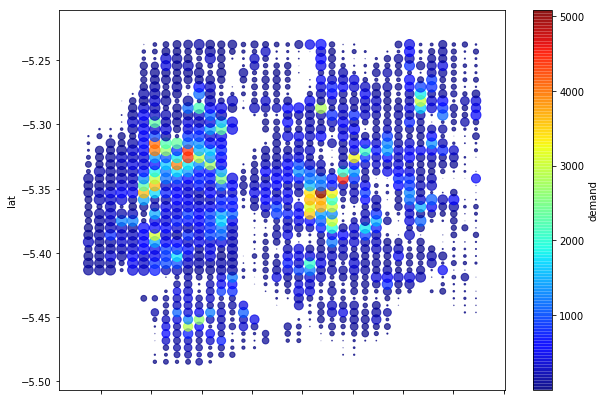

In [19]:
df.groupby(["lat", "long"]).demand.sum().reset_index().plot(
    kind="scatter", 
    x="long", y="lat", 
    c="demand", 
    s=df.groupby(["lat", "long"]).demand.count().reset_index().demand / 50,
    cmap=plt.get_cmap("jet"), colorbar=True, alpha=0.7, figsize=(10,7))

Based on the marker sizes, the number of data points (location + timestamp) is very sparse which mean we have to impute the missing data points.

In [20]:
df = impute_data(df, lat_long_map)

In [21]:
df.to_feather("../data/eda_imputed.feather")

## 6. Explore

In [22]:
df = pd.read_feather("../data/eda_imputed.feather")

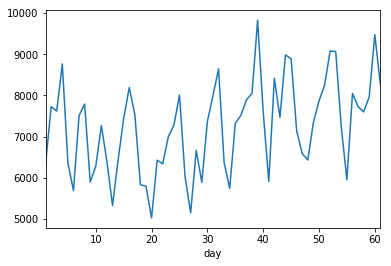

In [23]:
df.groupby("day").demand.sum().plot(kind="line")

Some weekly seasonality present in the data and .

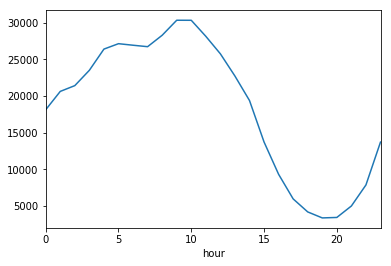

In [24]:
df.groupby("hour").demand.sum().plot(kind="line")

It's interesting to see that demands are at their lowest point around 20 PM but start increasing right after.

In [25]:
class LoopingPillowWriter(animation.PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)

In [26]:
fig, ax = plt.subplots()

ax.grid()
ax.set_xlim([0, 24])
ax.set_ylim([0, 1.2e3])

line, = ax.plot([], [])

plt.close()

def init():
    line.set_data([], [])

def animate(day, data):
    current_data = data[data.day == day].groupby("hour", as_index=False).demand.sum()
    line.set_data(current_data.hour, current_data.demand)
    ax.set_title(f"Day {day}")

anim = animation.FuncAnimation(fig, animate, fargs=(df,), frames=range(1,62), init_func=init)

anim.save("./eda_line_hourly_demand.gif", writer=LoopingPillowWriter(fps=2))

Image(url="./eda_line_hourly_demand.gif")

Hourly demand distribution seems pretty stable throughout the days.

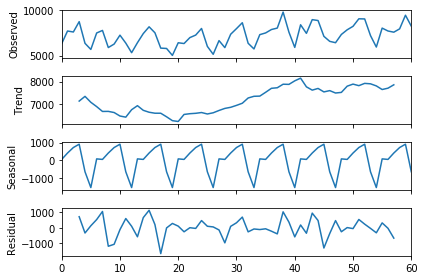

In [27]:
res = seasonal_decompose(df.groupby("day", as_index=False).demand.sum().demand, freq=7)
res.plot()
plt.show()

In [28]:
fig, ax = plt.subplots()
ax.set_xlim([df.long.min(), df.long.max()])
ax.set_ylim([df.lat.min(), df.lat.max()])
scatter = ax.scatter([], [])

plt.close()

def init():
    scatter.set_offsets([])

cmap = plt.get_cmap("jet")
    
def animate(day, data):
    current_data = data[data.day == day].groupby(["lat", "long"], as_index=False).demand.sum()
    norm = colors.Normalize(vmin=current_data.demand.min(), vmax=current_data.demand.max())
    scatter.set_offsets(np.c_[current_data.long, current_data.lat])
    scatter.set_color(cmap(norm(current_data.demand.to_list())))
    ax.set_title(f"Day {day}")

anim = animation.FuncAnimation(fig, animate, fargs=(df,), frames=range(1,62), init_func=init)

anim.save("./eda_scatter_daily_demand.gif", writer=LoopingPillowWriter(fps=2))

Image(url="./eda_scatter_daily_demand.gif")

Most of the demands are focused on certain locations, maybe they are important points and people are commuting from one to another everyday.

In [29]:
df = pd.read_feather("../data/eda_imputed.feather")

fig, ax = plt.subplots()
ax.set_xlim([df.long.min(), df.long.max()])
ax.set_ylim([df.lat.min(), df.lat.max()])
scatter = ax.scatter([], [])

plt.close()

def init():
    scatter.set_offsets([])

cmap = plt.get_cmap("jet")
    
def animate(index, data):
    day, hour, minute = index
    current_data = data[(data.day == day) & (data.hour == hour) & (data.minute == minute)]
    norm = colors.Normalize(vmin=current_data.demand.min(), vmax=current_data.demand.max())
    scatter.set_offsets(np.c_[current_data.long, current_data.lat])
    scatter.set_color(cmap(norm(current_data.demand.to_list())))
    ax.set_title(f"Day {day} Hour {hour} Minute {minute}")

anim = animation.FuncAnimation(fig, animate, 
                               fargs=(df,), 
                               frames=[(d,h,m) for d in range(1,2) for h in range(0,23) for m in range(0,60,15)], 
                               init_func=init)

anim.save("./eda_scatter_minutely_demand.gif", writer=LoopingPillowWriter(fps=2))

Image(url="./eda_scatter_minutely_demand.gif")

Demands in certain locations keep being higher than others throughout the timestamp.